# Comparing the stray field of a sphere with a dipolar field

**Author:** Maximilian Albert

**Date:** Jun 2014

**Purpose:** We compute the stray field of a uniformly magnetised sphere (using the airbox method) and compare it with the field created by a point dipole with the same magnetic moment. This allows to check how accurate the demag calculation is, and how quickly it converges for finer mesh discretizations.

In [1]:
from __future__ import division
from finmag.example import sphere_inside_airbox
from finmag.util import helpers
from finmag.util.meshes import mesh_volume, mesh_info, plot_mesh_with_paraview
from finmag.energies.zeeman import DipolarField
import numpy as np
import sys
import finmag
finmag.set_logging_level('INFO')
#np.set_printoptions(precision=1e-8)

[2014-06-09 18:36:56] INFO: Finmag logging output will be appended to file: '/home/albert/.finmag/global.log'
[2014-06-09 18:36:56] DEBUG: Building modules in 'native'...
[2014-06-09 18:36:57] DEBUG: FinMag          5047:e8225c1b7a79ea431efa470d26532258c63bb6ef
[2014-06-09 18:36:57] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.1               
[2014-06-09 18:36:57] DEBUG: Numpy           1.8.1                Scipy           0.12.0              
[2014-06-09 18:36:57] DEBUG: IPython         2.1.0                Python          2.7.5+              
[2014-06-09 18:36:57] DEBUG: Paraview        4.0.1-1              Sundials        2.5.0               
[2014-06-09 18:36:57] DEBUG: Boost-Python    <unknown>            Linux           Linux Mint 16 Petra 
[2014-06-09 18:36:57] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


## Creating the simulation

We begin by defining the relevant parameters. The mesh is a sphere contained inside a box (representing the 'air'), and we define the relevant geometry parameters and magnetisation of the sphere.

In [2]:
r_sphere = 3.0
r_shell = 30.0
l_box = 100.0
maxh_sphere = 4.0
Ms = 8.6e5
demag_atol = 1e-8
demag_rtol = 1e-8
m_init = [1, 0, 0]
#m_init = [7, -4, 3]  # some random magnetisation orientation

demag_solver_params = {'phi_1': {'absolute_tolerance': demag_atol, 'relative_tolerance': demag_rtol},
                       'phi_2': {'absolute_tolerance': demag_atol, 'relative_tolerance': demag_rtol}}

Next we create a simulation object with this mesh and the parameters defined above.

In [3]:
sim = sphere_inside_airbox(r_sphere=r_sphere, r_shell=r_shell, l_box=l_box,
                           maxh_sphere=maxh_sphere, maxh_box=10.0, maxh_shell=10.0,
                           Ms=Ms, m_init=m_init, demag_solver_params=demag_solver_params)

[2014-06-09 18:37:03] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:37:03] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:37:03] INFO: <Mesh of topological dimension 3 (tetrahedra) with 2360 vertices and 9483 cells, ordered>


We'd like to compare the stray field of the sphere to the field of a point dipole with an equivalent magnetic moment. Ideally, we could just use the volume of a perfect sphere to compute this magnetic moment. However, the spherical mesh inside the box is only a tetrahedral approximation, so the volumes are different.

In [4]:
mesh_sphere = sim.get_submesh('sphere')
print "Volume of sphere: {}".format(4./3*pi*r_sphere**3)
print "Volume of spherical mesh: {}".format(mesh_volume(mesh_sphere))

Volume of sphere: 113.097335529
Volume of spherical mesh: 102.753226719


This is what the mesh of the sphere looks like.

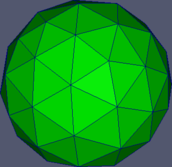

In [5]:
plot_mesh_with_paraview(mesh_sphere, rescale=0.5)

Next we create a field representing a point dipole whose magnetic moment is the same as that of the spherical mesh and add it to the simulation.

In [6]:
vol = mesh_volume(mesh_sphere)
H_dipole = DipolarField(pos=(0, 0, 0), m=m_init, magnitude=Ms*vol)
sim.add(H_dipole)

In [7]:
#print mesh_info(sim.get_submesh('sphere'))

## Plotting the fields

In [8]:
def probe_field(sim, field_name, N):
    """
    Probe the field on a regular grid of N x N points in the xz-plane.
    Only the 'air' region of the field is probed, all values outside
    that region are masked out.

    """
    coords = sim.mesh.coordinates()
    xmin = coords[:, 0].min(); zmin = coords[:, 0].min()
    xmax = coords[:, 0].max(); zmax = coords[:, 0].max()
    xvals = np.linspace(xmin, zmax, N)
    zvals = np.linspace(zmin, zmax, N)
    pts = np.array([[[x, 0.0, z] for z in zvals] for x in xvals])
    vals = sim.probe_field(field_name, pts, region='air')
    return pts, vals

In [9]:
def plot_field(sim, field_name, N, type='heatmap', figsize=(4, 4)):
    """
    Plot a cross-section of the field in the xz-plane.
    Supported plot types are: 'heatmap' and 'quiver'.

    """
    pts, vals = probe_field(sim, field_name, N)

    X = pts[:, :, 0]  # x-coordinates of mesh vertices
    Z = pts[:, :, 2]  # z-coordinates of mesh vertices
    U = vals[:, :, 0]  # x-coordinates of demag field vectors
    V = vals[:, :, 2]  # z-coordinates of demag field vectors
    
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    if type == 'heatmap':
        im = ax.imshow(vals[:, :, 0], cmap=cm.hot)
        fig.colorbar(im)
    elif type == 'quiver':
        C = vals[:, :, 0]  # colour arrows by x-coordinate of field vectors
        im = quiver(X, Z, U, V, C, pivot='middle', cmap=cm.hot)
        ax.set_aspect('equal')
        fig.colorbar(im)

### Stray field of the sphere

First we plot the demag field in the air region (i.e., the stray field of the sphere). We show both a heatmap and a vector field plot.

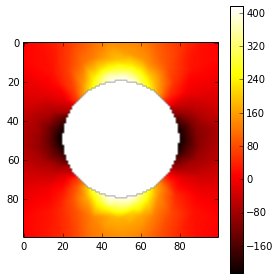

In [14]:
plot_field(sim, 'Demag', N=100, type='heatmap')

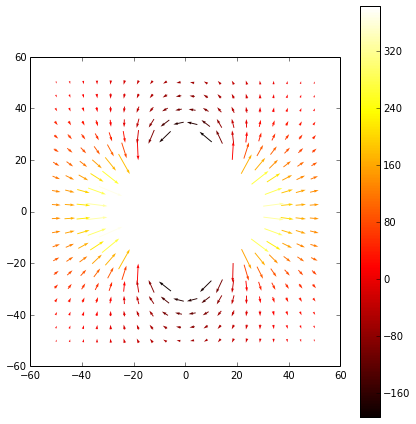

In [11]:
plot_field(sim, 'Demag', N=20, type='quiver', figsize=(6, 6))

### Dipolar field

The field of the point dipole looks almost identical, which is a good sign.

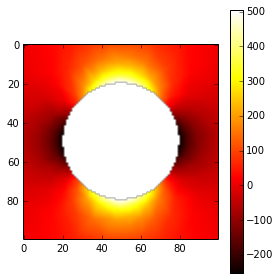

In [12]:
plot_field(sim, 'DipolarField', N=100, type='heatmap')

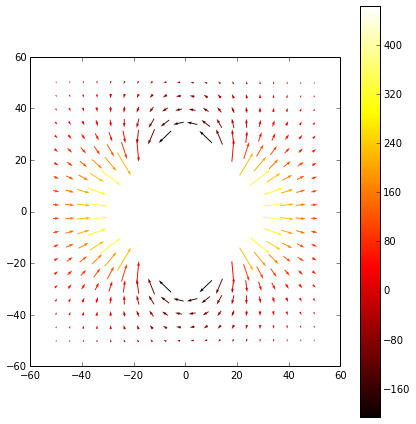

In [13]:
plot_field(sim, 'DipolarField', N=20, type='quiver', figsize=(6, 6))

## Visualising the errors

Next we compute the errors fields and visualise them by various means.

In [16]:
pts, vals_demag = probe_field(sim, 'Demag', N=100)
pts, vals_dipole = probe_field(sim, 'DipolarField', N=100)
abserr = np.linalg.norm(vals_demag - vals_dipole, axis=2)
relerr = np.ma.masked_invalid(abserr / np.linalg.norm(vals_dipole, axis=2))

First we show a histogram of the absolute errors. Most of them are very small, which represents the fact that the dipolar field rapidly decays with increasing distance from the sphere.

(array([  3.77500000e+03,   1.66500000e+03,   1.31000000e+03,
          8.95000000e+02,   6.70000000e+02,   4.60000000e+02,
          2.54000000e+02,   1.78000000e+02,   1.31000000e+02,
          8.40000000e+01,   8.90000000e+01,   5.40000000e+01,
          4.80000000e+01,   4.00000000e+01,   3.80000000e+01,
          3.90000000e+01,   4.30000000e+01,   3.80000000e+01,
          4.00000000e+01,   3.40000000e+01,   2.20000000e+01,
          2.40000000e+01,   2.40000000e+01,   1.30000000e+01,
          1.50000000e+01,   6.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   1.00000000e+00,   1.00000000e+00]),
 array([   0.        ,    3.70379403,    7.40758806,   11.11138209,
          14.81517612,   18.51897015,   22.22276418,   25.92655822,
          29.63035225,   33.33414628,   37.03794031,   40.74173434,
          44.44552837,   48.1493224 ,   51.85311643,   55.55691046,
          59.26070449,   62.96449852,   66.66829255,   70.37208658,
          74.07588061,   77.77967465, 

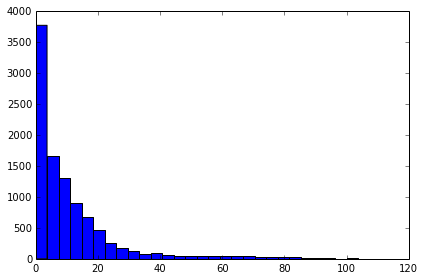

In [21]:
# IPYTHON_TEST_IGNORE_OUTPUT
hist(abserr.ravel(), bins=30)

The relative errors are more evenly distributed around a non-zero value.

(array([ 297.,  868.,  904.,  779.,  718.,  571.,  441.,  354.,  359.,
         307.,  321.,  225.,  176.,  160.,  128.,  108.,  100.,   83.,
          83.,   59.,   38.,   42.,   40.,   19.,   22.,   11.,    7.,
           7.,   13.,    5.]),
 array([ 0.00207603,  0.01847498,  0.03487393,  0.05127287,  0.06767182,
         0.08407077,  0.10046971,  0.11686866,  0.13326761,  0.14966655,
         0.1660655 ,  0.18246444,  0.19886339,  0.21526234,  0.23166128,
         0.24806023,  0.26445918,  0.28085812,  0.29725707,  0.31365602,
         0.33005496,  0.34645391,  0.36285286,  0.3792518 ,  0.39565075,
         0.4120497 ,  0.42844864,  0.44484759,  0.46124653,  0.47764548,
         0.49404443]),
 <a list of 30 Patch objects>)

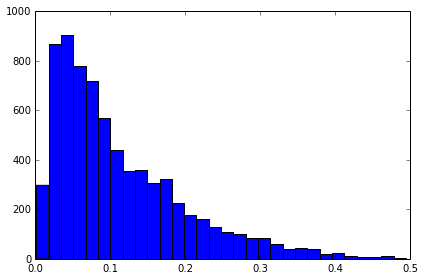

In [22]:
# IPYTHON_TEST_IGNORE_OUTPUT
hist(relerr[numpy.isfinite(relerr)].ravel(), bins=30)

In [24]:
# IPYTHON_TEST_IGNORE_OUTPUT
print "Maximum absolute difference: {}".format(abserr.max())
print "Mean absolute difference: {}".format(abserr.mean())
print "Maximum relative difference: {}".format(relerr.max())
print "Mean relative difference: {}".format(relerr.mean())

Maximum absolute difference: 111.113820922
Mean absolute difference: 10.7848269452
Maximum relative difference: 0.494044427848
Mean relative difference: 0.112298876826


Here is a heatmap of the absolute differences. We can see that the largest differences occur near the sphere itself, as is expected because these are also the locations with the larges field values.

<matplotlib.colorbar.Colorbar instance at 0x6128ab8>

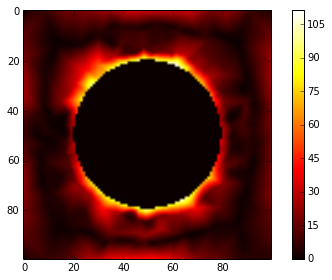

In [20]:
imshow(abserr, cmap=cm.hot)
colorbar()

The relative differences show a more interesting distribution. Oddly, there seems to be a small region inside the airbox where the relative differences are virtually zero.

<matplotlib.colorbar.Colorbar instance at 0x64eacf8>

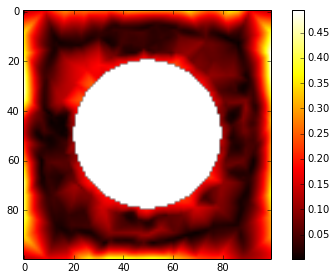

In [21]:
imshow(relerr, cmap=cm.hot)
colorbar()

## Plotting the errors as a function of mesh discretization

Here we compute the absolute and relative errors on a range of increasingly fine meshes. This allows us to see how the errors decay as `maxh` gets smaller.

In [22]:
def compute_field_err(maxh, atol=1e-6, rtol=1e-6):
    demag_solver_params = {'phi_1': {'absolute_tolerance': atol, 'relative_tolerance': rtol},
                           'phi_2': {'absolute_tolerance': atol, 'relative_tolerance': rtol}}
    sim = sphere_inside_airbox(r_sphere=r_sphere, r_shell=r_shell, l_box=l_box,
                               maxh_sphere=maxh, maxh_box=10.0, maxh_shell=10.0, Ms=Ms,
                               m_init=m_init, demag_solver_params=demag_solver_params)
    print "Sphere volume: {:.2f}".format(mesh_volume(sim.get_submesh('sphere')))
    sim.add(H_dipole)
    vals_demag = sim.get_field_as_dolfin_function('Demag', region='air').vector().array().reshape(3, -1)
    vals_dipole = sim.get_field_as_dolfin_function('DipolarField', region='air').vector().array().reshape(3, -1)
    abserr = np.linalg.norm(vals_demag - vals_dipole, axis=0)
    relerr = abserr / np.linalg.norm(vals_dipole, axis=0)
    return abserr, relerr

In [23]:
abserrs = {}
relerrs = {}

In [24]:
maxhs = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [25]:
for maxh in maxhs:
    if not (maxh in abserrs and maxh in relerrs):
        print("DDD maxh={}".format(maxh))
        sys.stdout.flush()
        abserrs[maxh], relerrs[maxh] = compute_field_err(maxh=maxh, atol=1e-10, rtol=1e-10)

DDD maxh=1.5


[2014-06-09 18:32:10] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:10] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:10] INFO: <Mesh of topological dimension 3 (tetrahedra) with 14134 vertices and 65177 cells, ordered>


Sphere volume: 102.75
DDD maxh=2.0


[2014-06-09 18:32:27] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:27] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:27] INFO: <Mesh of topological dimension 3 (tetrahedra) with 7258 vertices and 31683 cells, ordered>


Sphere volume: 102.75
DDD maxh=2.5


[2014-06-09 18:32:35] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:35] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:35] INFO: <Mesh of topological dimension 3 (tetrahedra) with 5429 vertices and 24131 cells, ordered>


Sphere volume: 102.75
DDD maxh=3.0


[2014-06-09 18:32:40] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:40] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:40] INFO: <Mesh of topological dimension 3 (tetrahedra) with 4023 vertices and 17675 cells, ordered>


Sphere volume: 102.75
DDD maxh=3.5


[2014-06-09 18:32:43] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:43] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:43] INFO: <Mesh of topological dimension 3 (tetrahedra) with 3045 vertices and 12858 cells, ordered>


Sphere volume: 102.75
DDD maxh=4.0


[2014-06-09 18:32:46] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:46] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:46] INFO: <Mesh of topological dimension 3 (tetrahedra) with 2360 vertices and 9483 cells, ordered>


Sphere volume: 102.75
DDD maxh=5.0


[2014-06-09 18:32:48] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:48] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:48] INFO: <Mesh of topological dimension 3 (tetrahedra) with 1952 vertices and 7894 cells, ordered>


Sphere volume: 102.75
DDD maxh=6.0


[2014-06-09 18:32:49] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:49] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:49] INFO: <Mesh of topological dimension 3 (tetrahedra) with 1669 vertices and 6572 cells, ordered>


Sphere volume: 102.75
DDD maxh=7.0


[2014-06-09 18:32:50] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:50] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:50] INFO: <Mesh of topological dimension 3 (tetrahedra) with 1226 vertices and 4180 cells, ordered>


Sphere volume: 102.75
DDD maxh=8.0


[2014-06-09 18:32:51] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:51] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:51] INFO: <Mesh of topological dimension 3 (tetrahedra) with 1165 vertices and 3962 cells, ordered>


Sphere volume: 102.75
DDD maxh=9.0


[2014-06-09 18:32:52] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:52] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:52] INFO: <Mesh of topological dimension 3 (tetrahedra) with 1054 vertices and 3444 cells, ordered>


Sphere volume: 102.75
DDD maxh=10.0


[2014-06-09 18:32:53] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/sphere_inside_airbox.log' (any old content will be overwritten).
[2014-06-09 18:32:53] INFO: Creating Sim object 'sphere_inside_airbox' (rank=0/1).
[2014-06-09 18:32:53] INFO: <Mesh of topological dimension 3 (tetrahedra) with 1021 vertices and 3309 cells, ordered>


Sphere volume: 102.75


In [26]:
def plot_errs(abs_or_rel, fun):
    errs = {'absolute': abserrs, 'relative': relerrs}[abs_or_rel]
    xvals, yvals = zip(*sorted([(k, fun(v)) for (k, v) in errs.items()]))
    plot(xvals, yvals, 'o-')
    ylim(0, 1.05*max(yvals))
    title('{} of {} error'.format(fun.__name__, abs_or_rel))
    xlabel('maxh')

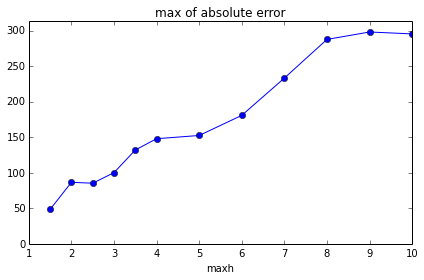

In [27]:
plot_errs('absolute', max)

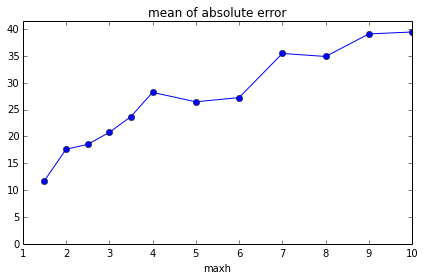

In [28]:
plot_errs('absolute', np.mean)

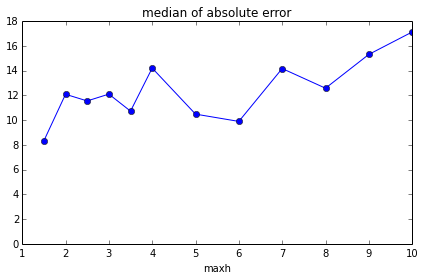

In [30]:
plot_errs('absolute', np.median)

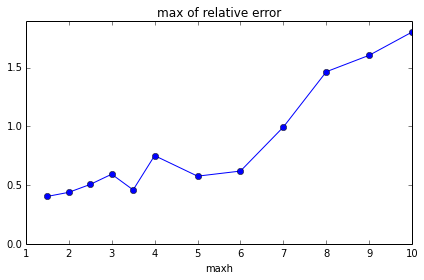

In [31]:
plot_errs('relative', max)

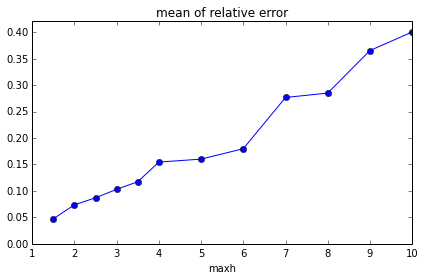

In [32]:
plot_errs('relative', np.mean)

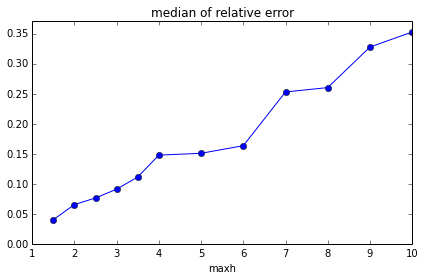

In [33]:
plot_errs('relative', np.median)